# Acelerando aplicações com CUDA C/C++

* CUDA é um acrônimo para Compute Unified Device Architecture.
* É uma API criada pela NVIDIA para Computação Paralela em suas GPUS, portanto precisamos de uma GPU da NVIDIA para programar em CUDA. Entretanto, existem ferramentas que tentam integrar GPU's da AMD com o código CUDA, como por exemplo: [ZLUDA](https://github.com/vosen/ZLUDA?authuser=0)
* Um sistema acelerado, também conhecido como sistema heterogêneo, são sistemas compostos por uma CPU e uma GPU;

* Para obter informações da sua GPU NVIDIA que rodará seu código CUDA, utilize a CLI:

In [ ]:
!nvidia-smi

# CPU vs GPU
* Códigos rodados apenas na CPU geralmente são serializados, isto é, a chamada de uma função fará uma série de instruções sequencialmente. Quando trabalhamos com CUDA, podemos ter processamento em paralelo nos dados por parte da GPU, enquanto a CPU trabalha com outros dados, o que nos faz ganhar tempo. Para armazenar dados na GPU e ganharmos acesso a este processamento paralelo, chamamos cudaMallocManaged(). É importante ressaltar que trabalhar na GPU é um processo assíncrono, já que a CPU trabalha ao mesmo tempo. Portanto, para sincronizá-los, chamamos cudaDeviceSynchronize() para que a CPU seja sincronizada com a GPU, isto é, aguardar a GPU terminar o trabalho dela. Depois disso podemos por exemplo acessar os dados processados pela GPU na CPU novamente.

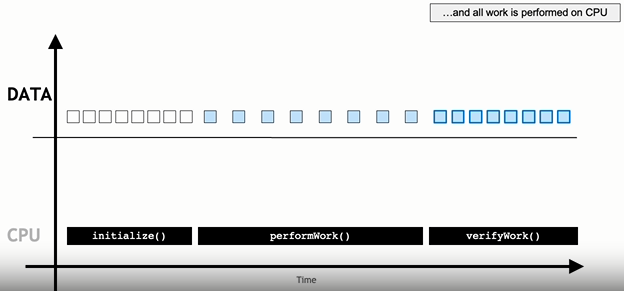

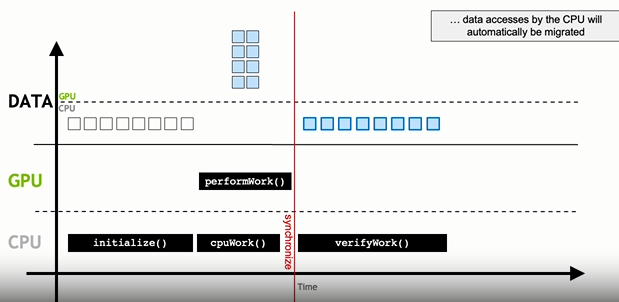

# Escrevendo códigos para GPU

* .cu é a extensão para arquivos CUDA

```cpp
void CPUFunction()
{
  printf("This function is defined to run on the CPU.\n");
}

__global__ void GPUFunction()
{
  printf("This function is defined to run on the GPU.\n");
}

int main()
{
  CPUFunction();

  GPUFunction<<<1, 1>>>();
  cudaDeviceSynchronize();
}
```

* O código acima possui duas funções: a primeira que será rodada na CPU e a segunda que será executada na GPU.
* A palavra-chave ```__global__``` indica que a função será rodada na GPU e pode ser invocada globalmente, o que neste contexto significa CPU e GPU.
* Geralmente, o código rodado na CPU é chamado de **HOST** code e o código rodado na GPU é chamado de **DEVICE** code.
* Quando uma função é chamada para ser executada na GPU, isto é, possui o pre-fixo __global__, chamamos esta função de **kernel** que é **inicializado/launched**.
* ``` GPUFunction<<<1, 1>>>(); ```
* ```<<< ... >>>``` através desta sintaxe colocamos as configurações de execução deste kernel, ou função da GPU, o primeiro parâmetro é o número de blocos e o segundo parâmetro é a quantidade de threads em cada bloco.
* ``` cudaDeviceSynchronize(); ```
* Diferente do código padrão de C/C++, inicializar kernels é uma tarefa assíncrona: o código da CPU continuará executando sem esperar o kernel finalizar.
* A chamada para ``` cudaDeviceSynchronize() ``` faz com que a CPU espere até o código executado na GPU termine para continuar.

# NVCC: NVIDIA CUDA Compiler
* Para compilar e roda seu programa em CUDA, utilizamos o ```nvcc``` que é bem parecido com o ```gcc```:

```nvcc -o out some-CUDA.cu -run```
* em que:
* some-CUDA.cu é o nosso arquivo CUDA
* out será o nome do nosso programa compilado
* run para executá-lo imediatamente
* OBS: para códigos não CUDA (host code), o nvcc chama o gcc para compilar, trabalhando apenas nos códigos CUDA (device code) (__global__)

In [ ]:
# Exemplo
!nvcc -o hello-gpu module1/hello-gpu.cu -run

# Recapitulando

* O trabalho da GPU é feito em paralelo.
* O trabalho de uma GPU é executado em uma thread.
* Muitas threads em uam GPU rodam paralelamente
* Uma coleção de threads é um bloco.
* Uma coleção de blocos é um grid.
* Funções da GPU são chamadas de kernel.
* Kernels são inicializados com uma configuração de execução. ``` <<< ... >>>```
* A configuração de execução define a quantidade de blocos no grid, como primeiro parâmetro, e a quantidade de threads em cada bloco, como segundo parâmetro.
* Todo bloco em um grid possui a mesma quantidade de threads.

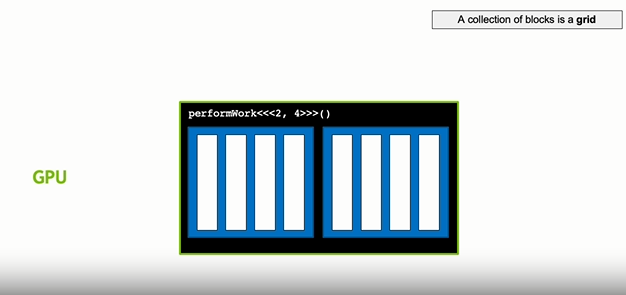

* Em branco, temos as threads
* Em azul, temos os blocos
* Em preto com bordas verdes, temos o grid

# Inicializando Kernels em paralelo

* ```<<< NUMBER_OF_BLOCKS, NUMBER_OF_THREADS_PER_BLOCK>>>```
* someKernel<<<1, 1>>>() é um kernel configurado para rodar em um único bloco, que contém uma única thread, portanto rodará 1 vez.
* someKernel<<<1, 10>>>() é um kernel configurado para rodar em um único bloco,
que contêm dez threads, portanto rodará 10 vezes.
* someKernel<<<10, 1>>>() é um kernel configurado para rodar em dez blocos, o qual cada um contêm 10 threads, portanto rodará 10 vezes.
* someKernel<<<10, 10>>>() é um kernel configurado para rodar em dez blocos, o qual cada um contêm 10 threads, portanto rodará 100 vezes.


* Exemplo em:
!nvcc -o first-parallel module1/first-parallel.cu -run

# Variáveis das Threads

 ##### 1. gridDim.x é o número de blocos em um grid
* No exemplo de performWork<<<2, 4>>>(), gridDim.x = 2
##### 2. blockIdx.x é o index do atual bloco que determinada thread está sendo executada.
* No exemplo de performWork<<<2, 4>>>(), blockIdx.x poderia assumir o valor 0 ou 1, visto que existem dois blocos e a indexação começa a partir do zero.
##### 3. Dentro de um kernel, temos blockDim.x que descreve o número de threads em um bloco.
* No exemplo de performWork<<<2, 4>>>(), blockDim.x teria valor 4, já que existem 4 threads em cada bloco, pelas configurações de execução.
* Vale ressaltar que todos os blocos de threads em um grid possuem a mesma quantidade de threads
##### 4. Dentro de um kernel, temos threadIdx.x descre o index de uma thread dentro de um bloco
* No exemplo de performWork<<<2, 4>>>(), threadIdx.x poderia assumir valor 0, 1, 2 e 3
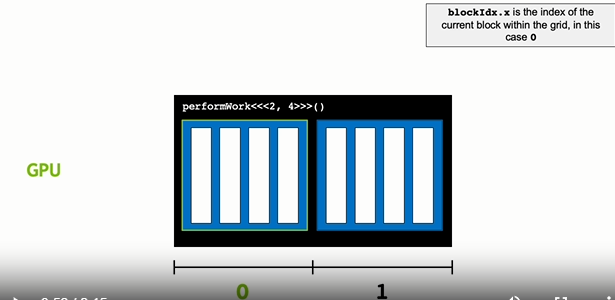
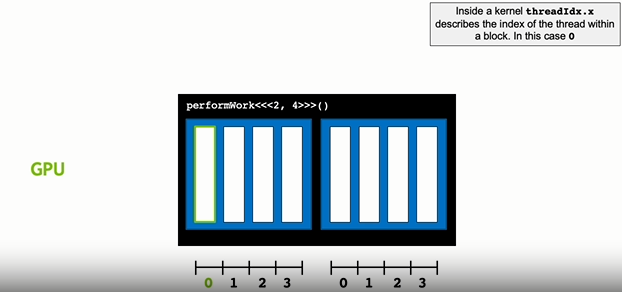

* Exemplo em:
!nvcc -o thread-and-block-idx 03-indices/01-thread-and-block-idx.cu -run

# Acelerando loops

* Loops rodados integralmente na CPU são serializados. 
```
int N = 2<<5; // 100000 = 2^5
for (int i = 0; i < N; ++i)
{
  printf("%d\n", i);
}
```
* Loops rodados na GPU podem ser rodados em paralelo por cada thread.
* Para paralelizar um loop precisamos de 2 passos:
* Um kernel escrito para fazer o trabalho de uma iteração ÚNICA do loop.
* Como o kernel será independente de outros kernels em execução, a configuração de execução deve ser tal que o kernel execute o número correto de vezes, por exemplo, o número de vezes que o loop teria iterado.
```
__global__ void loop()
{
    printf("This is iteration number %d\n", threadIdx.x);
}
```
```
int main()
{

  loop<<<1, 32>>>();
  cudaDeviceSynchronize();
}
```

In [2]:
# Exemplo
!nvcc -o single-block-loop module1/single-block-loop.cu -run

'nvcc' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


# Coordenando threads paralelas


* Lembrando que cada thread tem acesso ao tamanho do bloco via blockDim.x e também ao index do bloco naquele grid via blockIdx.x e tem seu próprio indice em seu bloco via threadIdx.x. Utilizando essas três variáveis, temos uma fórmula canônica para mapear as threads globalmente:
* Index global de cada thread: ```threadIdx.x + blockIdx.x*blockDim.x```
* Com isso, podemos mapear os nossos dados e associar cada um deles a uma única thread!
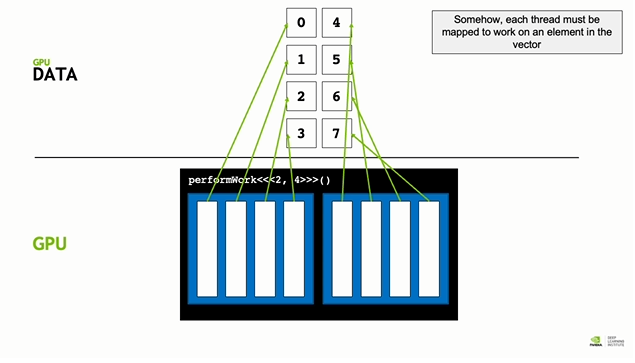
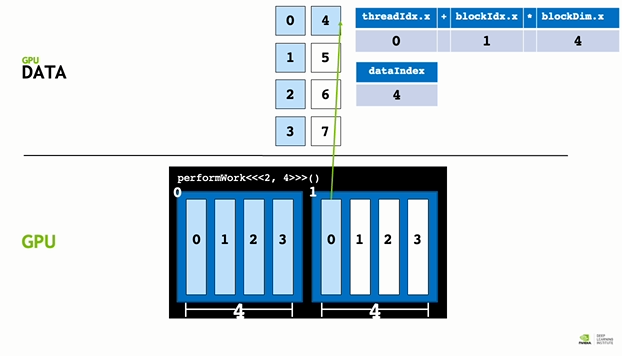

* Portanto, mapeando todos os dados para cada uma das threads, teríamos:

In [5]:
#    BLOCO     threadIdx.x  + blockIdx.x + blockDim.x   Global Idx
# 0. Bloco 0:       0              0           4         =   0
# 1. Bloco 1:       1              0           4         =   1
# 2. Bloco 2:       2              0           4         =   2
# 3. Bloco 3:       3              0           4         =   3
# 4. Bloco 4:       0              1           4         =   4
# 5. Bloco 5:       1              1           4         =   5
# 6. Bloco 6:       2              1           4         =   6
# 7. Bloco 7:       3              1           4         =   7

# O limite das threads

* Existe um limite de 1024 threads por cada bloco. 
* Para aumentar o percentual de paralelismo nas nossas aplicações aceleradas, precisamos coordenar múltiplos blocos de threads, utilizando este mapeamento global acima.
* Levando em consideração um kernel com a seguinte configuração de execução:

``` <<<10, 10>>> ```, teríamos 100 threads no total, 10 blocos com 10 threads cada.
* Se o bloco blockIdx.x é igual a 0, então blockIdx.x*blockDim.x é 0. Então adicionando isso ao threadIdx.x que varia entre 0 e 9, poderíamos obter índices entre 0 e 9.
* Se o bloco blockIdx.x é igual a 1, então blockIdx.x*blockDim.x é 10. Então adicionando isso ao threadIdx.x que varia entre 0 e 9, poderíamos obter índices entre 10 e 19, dentre os 100 índices.
* Se o bloco blockIdx.x é igual a 5, então blockIdx.x*blockDim.x é 50. Então adicionando isso ao threadIdx.x que varia entre 0 e 9, poderíamos obter índices entre 50 e 59, dentre os 100 índices.
* Se o bloco blockIdx.x é igual a 9, então blockIdx.x*blockDim.x é 90. Então adicionando isso ao threadIdx.x que varia entre 0 e 9, poderíamos obter índices entre 90 e 99, dentre os 100 índices (que variam de 0 a 99).

# Alocando memoria na GPU

* Tradicionalmente, para alocarmos memória na CPU, estamos acostumados com:
```
int N = 2<<20;
size_t size = N * sizeof(int);
```
```
int*a;
a = (int *)malloc(size);
// Utiliza a variável 'a' na CPU
free(a);
```
* Para GPU, temos:
```
int N = 2<<20;
size_t size = N*sizeof(int);
```
```
int *a;
cudaMallocManaged(&a, size);
// Utiliza a variável 'a' na CPU ou para algum processamento na GPU chamando algum kernel.
cudaFree(a);
```

* Observação: variáveis alocadas na CPU com malloc NÃO podem ser utilizadas em device code, isto é, por kernels rodadados na GPU. Se quisermos ter a possibilidade de trabalhar nos dois lados, CPU e GPU, devemos alocar com ``` cudaMallocManaged()```

# E se tivermos menos dados que threads?

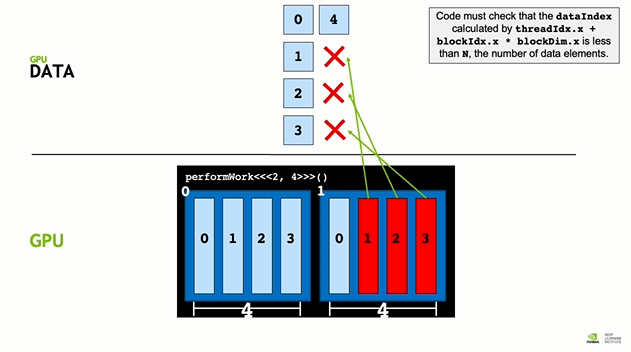

* Temos que ter cuidado para acessar elementos nao existentes e causar runtime errors

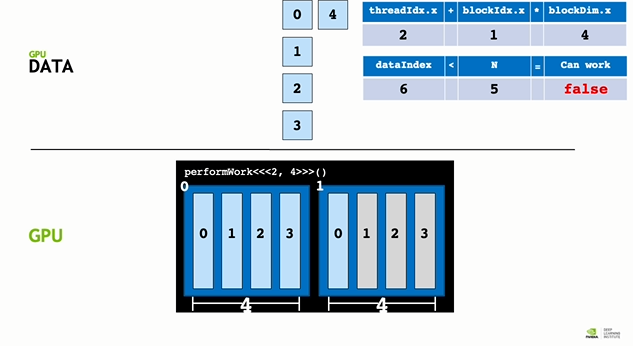

* Pode ser nosso programa exija uma quantidade de threads que não pode ser expressa por uma configuração de execução
* Devido a características do hardware da GPU, blocos que contenham um número de threads que seja um múltiplo de 32 geralmente são desejáveis para um bom desempenho. Por exemplo, supondo que desejamos lançar blocos, cada um contendo 256 threads (múltiplo de 32) e precisamos executar 1000 tarefas paralelas, então não há um número de blocos que produziria exatamente um total de 1000 threads no grid, já que não há um valor inteiro pelo qual 256 pode ser multiplicado para igualar exatamente 1000.
* Para solucionar este problema, tentamos optimizar a quantidade de blocos. Abordando-o da seguinte maneira:
1. Escreva uma configuração de execução que cria mais threads do que o necessário para fazer o trabalho alocado
2. Passe um valor como argumento para o kernel ('N') que represente o tamanho total do conjunto de dados a ser processado, ou o total de threads necessárias para concluir o trabalho. 
3. Depois de calcular o índice da thread dentro do grid (utilizando tid+bid*bdim) verifique se este índice não execede 'N' e execute apenas o traalho pertinente do kernel se não exceder.
* Exemplo
```cpp
// Assume que o N é conhecido
int N = 100000;
```
```
// Temos exatamente 256 threads por bloco
size_t threads_per_block = 256;
```

```
// Certifica que exista pelo menos N threads no Grid, com apenas um bloco extra
size_t number_of_blocks = (N + threads_per_block - 1) / threads_per_block;
```

```
some_kernel<<<number_of_blocks, threads_per_block>>>(N);
```

Como a configuração de execução acima resulta em mais threads no grid do que `N`, será necessário tomar cuidado dentro da definição de `some_kernel` para que `some_kernel` não tente acessar elementos de dados fora do intervalo, ao ser executado por uma das threads extras

```cpp
__global__ some_kernel(int N)
{
  int idx = threadIdx.x + blockIdx.x * blockDim.x;

  if (idx < N) // Check to make sure `idx` maps to some value within `N`
  {
    // Only do work if it does
  }
}
```

* Para ver um exemplo resolvido: module1/mismatched-config-loop.cu
* Relembrando como compilar:

   ``` !nvcc -o mismatched-config-loop module1/mismatched-config-loop.cu -run ```

# Grid-Stride Loops

* Vimos acima como procedemos quando temos menos dados que threads, a solução é criar mais threads que temos de dados e simplesmente executá-las em cada dado/tarefa, utilizando um verificador do índice global, a fim de evitar erros em tempo de execução.

* Mas e se tivermos mais dados do que threads em um grid?

* As threads trabalharão em mais de um dado, em vários strides (passadas). Por exemplo:

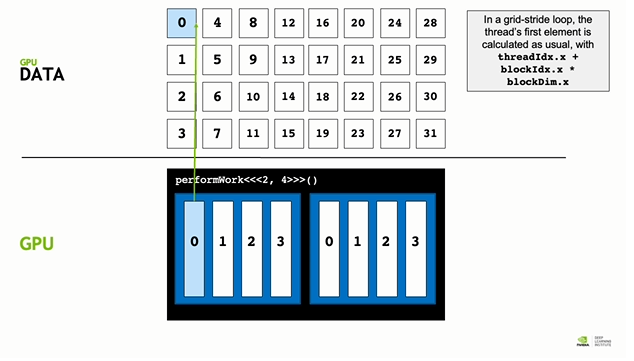

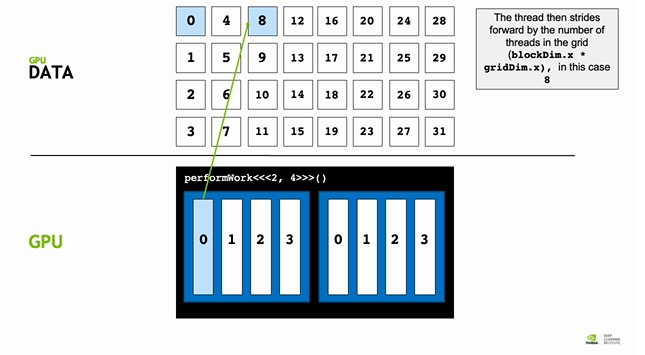

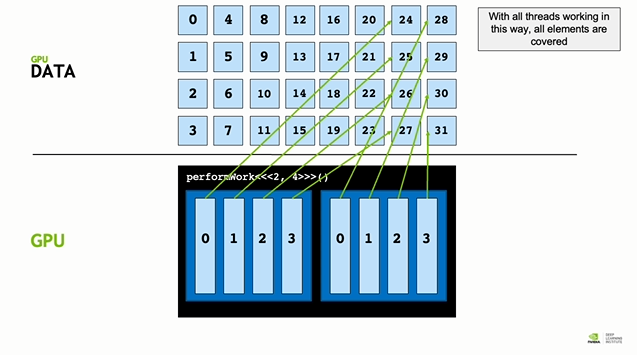

* Dessa forma, se considerarmos, por exemplo, um array com 1000 elementos e um grid com 250 threads. Cada thread, no grid, terá de ser usada 4 vezes. Em 4 passadas (strides)

* Em um exemplo mais concreto, imagine que tenhamos 500 elementos em um array e 250 threads em um grid. 
A thread com index 20:
    1. Será executada no elemento 20 dos 500's presentes no array.
    2. Incrementará 250 (um stride) e verificará se (20 + 250 = 270) ultrapassa a quantidade de elementos, se não passará a operar no elemento com index 20 + 250 = 270 dos 500.
    3. Incrementará 250 (mais um stride) e verificará se (270 + 250 = 520) ultrapassa a quantidade de elementos, como só temos 500 elementos e 520 > 500, ele não operará mais, se não teríamos um erro em tempo de execução.

* A CUDA fornece uma variável chamada gridDim.x que calcula o número total de blocos em um grid.
* Para calcular o stride, podemos fazer:

``` gridStride = gridDim.x * blockDim.x; ```

Relembrando as variáveis especiais do CUDA: 
* threadId.x: fornece um índice da thread local em um bloco. Por exemplo, se temos 4 threads em um bloco, threadId.x assume 0, 1, 2 e 3;
* blockIdx.x: fornece um índice do bloco local do grid. Por exemplo, se temos 2 blocos, blockIdx.x assume valores 0 e 1;
* blockDim.x: é um valor fixo e expressa a quantidade de threads em um bloco. Lembrando que em um grid, todos os blocos de threads possuem a mesma quantidade de threads, por isto o blockDim.x é único e fixo.

* Para calcular o index global da thread, utilizamos:

``` int globalThreadId = threadId.x + blockIdx.x*blockDim.x ```

* E agora, para calcular os stride (passada), que será o elemento imediatamente posterior a ser trabalhado por uma thread, fazemos:
``` gridStride = gridDim.x * blockDim.x; ```
* a partir da variável gridDim.x que calcula o número total de blocos em um grid.

```cpp
__global__ void kernel(int *a, int N)
{
  int indexWithinTheGrid = threadIdx.x + blockIdx.x * blockDim.x;
  int gridStride = gridDim.x * blockDim.x;

  for (int i = indexWithinTheGrid; i < N; i += gridStride)
  {
    // do work on a[i];
  }
}
```

* Um exercício resolvido sobre ter dados mais que threads, utilizando a técnica do Grid-Stride Loop, pode ser visto em:
    module1/grid-stride-double.cu
* Para compilar utilizando o nvcc, usamos:

``` nvcc -o grid-stride-double module1/grid-stride-double.cu -run ```

# Tratamento de Erros em CUDA

* Quase todos, se não todos os erros de CUDA são do tipo ``` cudaError_t ```

* Aqui um exemplo de tratamento de erro após a chamdada da ``` cudaMallocManaged ```:

```cpp
cudaError_t err;
err = cudaMallocManaged(&a, N)                    // Assume the existence of `a` and `N`.

if (err != cudaSuccess)                           // `cudaSuccess` is provided by CUDA.
{
  printf("Error: %s\n", cudaGetErrorString(err)); // `cudaGetErrorString` is provided by CUDA.
}
```

* Como os kernels lançados por nós são todos do tipo void, eles não retornam ``` cudaError_t ```. Por isso, existe a função ``` cudaGetLastError()  ``` que deve ser chamada para tratamento de erros ocorridos a partir da inicialização de kernels.

* É essencial que chamemos a ``` cudaDeviceSynchronize ``` depois de obter o último erro.

* a cudaDeviceSynchronize também retorna uma variável do tipo ``` cudaError_t ```, mas de modo assíncrono, isto é quando todas as threads terminarem ela retornará o erro, enquanto a cudaGetLastError obtem o erro imediatamente, sem esperar que as threads terminem.

Observação:     a ```cudaGetLastError()``` retorna um erro do tipo ``` cudaError_t ```

---
### CUDA Error Handling Function

It can be helpful to create a macro that wraps CUDA function calls for checking errors. Here is an example, feel free to use it in the remaining exercises:

```cpp
#include <stdio.h>
#include <assert.h>

inline cudaError_t checkCuda(cudaError_t result)
{
  if (result != cudaSuccess) {
    fprintf(stderr, "CUDA Runtime Error: %s\n", cudaGetErrorString(result));
    assert(result == cudaSuccess);
  }
  return result;
}

int main()
{

/*
 * The macro can be wrapped around any function returning
 * a value of type `cudaError_t`.
 */

  checkCuda( cudaDeviceSynchronize() )
}
```